In [28]:
import os
from glob import glob
import math
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.patches import Patch, Rectangle

import matplotlib

import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import scalebar

import rasterio as rio
from rasterio.warp import calculate_default_transform, reproject, Resampling, array_bounds


from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [2]:
matplotlib.figure.figaspect(.4)

array([10.,  4.])

In [3]:
%matplotlib inline

In [4]:
from skimage import exposure

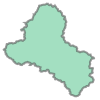

In [6]:
tuolumne = "/Users/tony/Downloads/tuo-head.geojson"
# tuolumne = "/Volumes/wrangell-st-elias/research/planet/locator-figure/co-watershed.geojson"
tuolumne = gpd.read_file(tuolumne)
tuolumne.geometry[0]

In [7]:
import geopandas as gpd
import json

In [8]:
%matplotlib inline

In [125]:
from shapely import geometry 

In [126]:
def get_raster_utm_epsg(dataset):
    lon, lat = list(geometry.Polygon.from_bounds(*dataset.bounds).centroid.coords)[0]
    utm_band = str((math.floor((lon + 180) / 6 ) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0'+utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return epsg_code

In [127]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs

import rasterio as rio

In [128]:
from rasterio.plot import show

In [9]:
root = "/Users/tony/Downloads/USCASJ_summaries/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-2020-01-21-21-37-55-126:planet-snowcover-imagery:20180601_181448_0f32_3B_AnalyticMS_SR_clip_tiled/"


In [19]:
os.listdir(root)

['data-mask.geojson', 'mask', 'preds']

In [10]:
imagepath = root.split("/")[-2].split(":")[-1]
print(imagepath)

20180601_181448_0f32_3B_AnalyticMS_SR_clip_tiled


In [21]:
mask_ds = rio.open(glob(os.path.join(root, "mask/*merged*.tif"))[0])
mask_data = mask_ds.read(1, masked=True)
nozero_mask = np.ma.masked_array(mask_data, mask_data == 0)

In [22]:
extent = [mask_ds.bounds[0], mask_ds.bounds[2], mask_ds.bounds[1], mask_ds.bounds[3]]
extent

[-119.1357421875, -118.883056640625, 37.41379857298404, 37.50101042949327]

In [23]:
nir_image = rio.open(glob(os.path.join(root, "*clip.tif"))[0])


IndexError: list index out of range

In [24]:
data_region = gpd.read_file(os.path.join(root, "data-mask.geojson"))

In [25]:
tuolumne.bounds

,minx,miny,maxx,maxy
0,-119.5455,37.739404,-119.199275,38.09415


NameError: name 'geometry' is not defined

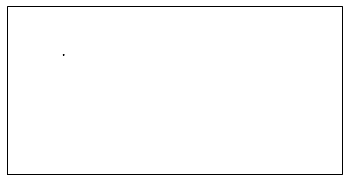

In [29]:
ax = plt.axes(projection=ccrs.PlateCarree(), frameon=False)
ax.margins(2, 2) 
scaling=0.2
ax.add_geometries(tuolumne.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1.2)
ax.add_geometries([geometry.Polygon.from_bounds(*(data_region.bounds.values[0]))], crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none')
ax.set_extent([tuolumne.bounds.minx-scaling, tuolumne.bounds.maxx+scaling, tuolumne.bounds.miny-scaling, tuolumne.bounds.maxy+scaling])
ax.outline_patch.set_linewidth(0)
scalebar.scale_bar(ax, (0.8,0.9), 10, linewidth=8, text_offset=0.04)

In [27]:
tuolumne.bounds.values

array([[-119.54550029,   37.7394043 , -119.19927543,   38.09415022]])

In [30]:
def plot_mask(mask, extent, ax, cmap, alpha=1):
    
    im = ax.imshow(mask, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=0.5, vmax = 1, cmap=cmap, alpha=alpha)
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False
    gl.ylabels_right = False

    
def plot_diff(mask, pred, extent, ax, alpha=1):
    diff = mask - pred
    im = ax.imshow(diff, extent=extent, transform=ccrs.PlateCarree(), origin='upper', vmin=-1, vmax=1, cmap='RdBu', alpha=alpha)
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabels_top = False
    gl.ylabels_right = False
    return(im)


In [31]:
nodata_diff = geometry.Polygon.from_bounds(*mask_ds.bounds).difference(data_region.geometry.iloc[0])

NameError: name 'geometry' is not defined

In [32]:
extent

[-119.1357421875, -118.883056640625, 37.41379857298404, 37.50101042949327]

In [33]:
nir_image = rio.open(glob(os.path.join(root, "*clip.tif"))[0])

nir_reproject = None
ndsi_reproject = None
with nir_image as src:
    transform, width, height = calculate_default_transform(
        src.crs, "EPSG:4326", src.width, src.height, *src.bounds)

    
    green = src.read(2, masked=True) 
    NIR = src.read(4, masked=True) 
    ndsi = (green - NIR) / (green + NIR)
    
    ndsi_reproject = np.zeros((height, width), dtype=float)

    reproject(
        source=ndsi / 10000,
        src_nodata=src.nodata, 
        dst_nodata=src.nodata,
        destination=ndsi_reproject,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs="EPSG:4326",
        resampling=Resampling.nearest)

    nir_reproject = np.zeros((height, width), dtype=float)
    reproject(
        source=src.read(4) / 10000,
        src_nodata=src.nodata, 
        dst_nodata=src.nodata,
        destination=nir_reproject,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=transform,
        dst_crs="EPSG:4326",
        resampling=Resampling.nearest)
    
    nir_reproject = np.ma.masked_array(nir_reproject, nir_reproject == src.nodata)
    bounds = array_bounds(height, width, transform)
    image_reproject_extent = [bounds[0], bounds[2], bounds[1], bounds[3]]


IndexError: list index out of range

In [34]:
adjusted_rgb = np.stack([
    exposure.equalize_adapthist(rgb_reproject[i]) for i in range(rgb_reproject.shape[0])
])

NameError: name 'rgb_reproject' is not defined

In [35]:
ndsi = 

SyntaxError: invalid syntax (<ipython-input-35-540b1f4d85de>, line 1)

In [36]:
adjusted_rgb.shape

NameError: name 'adjusted_rgb' is not defined

In [37]:
image_reproject_extent


NameError: name 'image_reproject_extent' is not defined

In [38]:
extent

[-119.1357421875, -118.883056640625, 37.41379857298404, 37.50101042949327]

NameError: name 'nodata_diff' is not defined

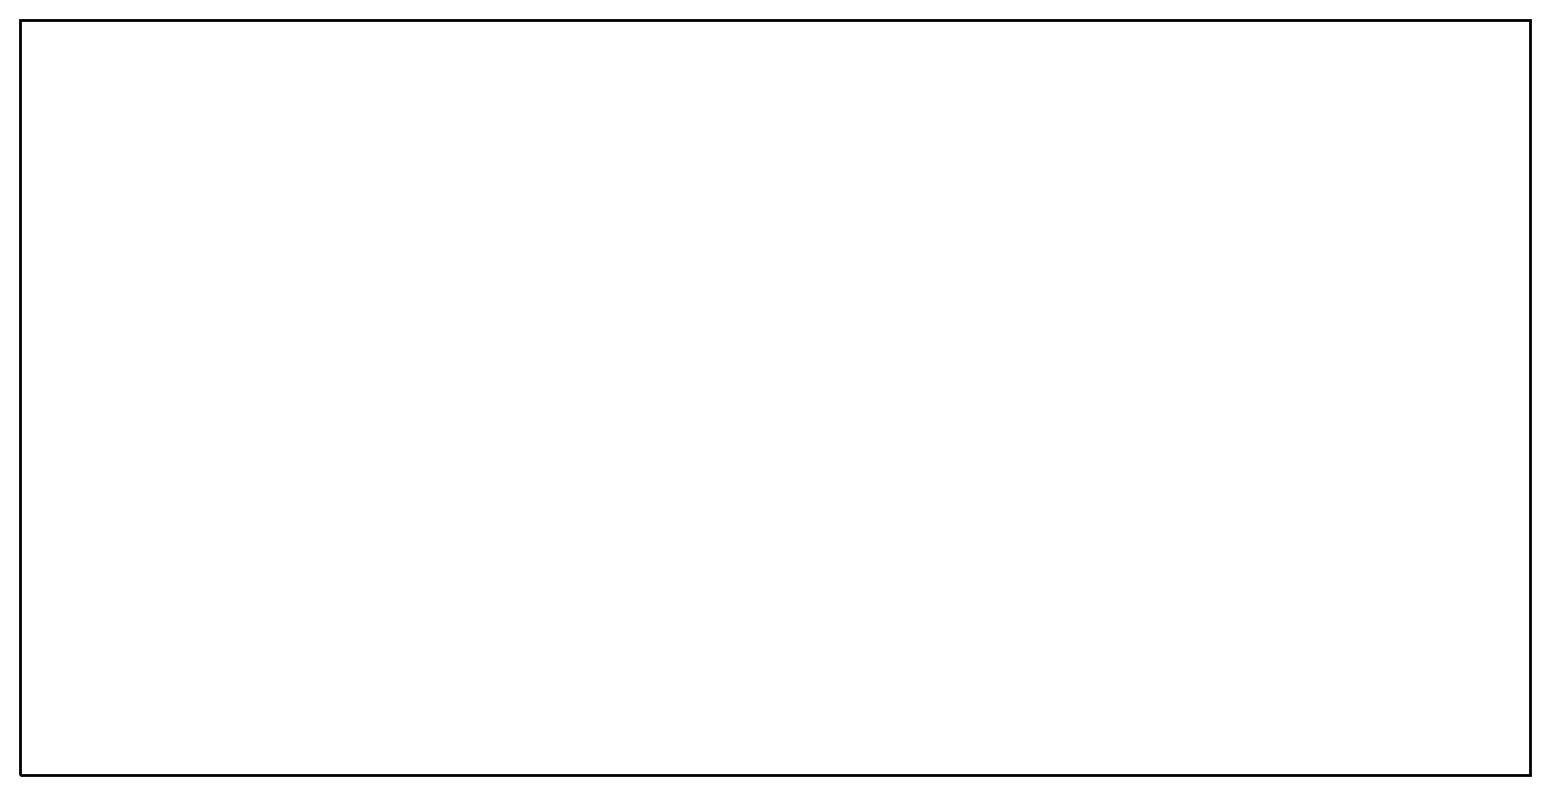

In [39]:
fig = plt.figure(figsize=(10,5), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)

cmap = plt.cm.get_cmap("Reds", 2)
# rgb = np.moveaxis(adjusted_rgb, 0, 2)

ax.imshow(exposure.equalize_hist(nir_reproject.data), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')
# ax.imshow(np.moveaxis(exposure.equalize_hist(rgb_reproject), 0, 2), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')


plot_mask(nozero_mask, extent, ax, cmap=cmap, alpha=0.9)

ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.5)


ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
    (Patch(facecolor=cmap(1), label='Snow Mask'))
]

ax.legend(handles=legendParts)

ax.text(0.01, 0.02, "Includes material © 2020 Planet Labs Inc. All Rights Reserved.".format("_".join(imagepath.split('_')[:3])), transform=ax.transAxes, fontdict={'color': 'white', 'fontsize' : 7})

ax.set_extent(extent, crs=ccrs.PlateCarree())
plt.savefig("test_image.png")

In [144]:
pred_ds = rio.open(glob(os.path.join(root, "preds/*merged*.tif"))[0])
pred_data = pred_ds.read(1, masked=True)
nozero_pred = np.ma.masked_array(pred_data, pred_data == 0)

NameError: name 'nir_reproject' is not defined

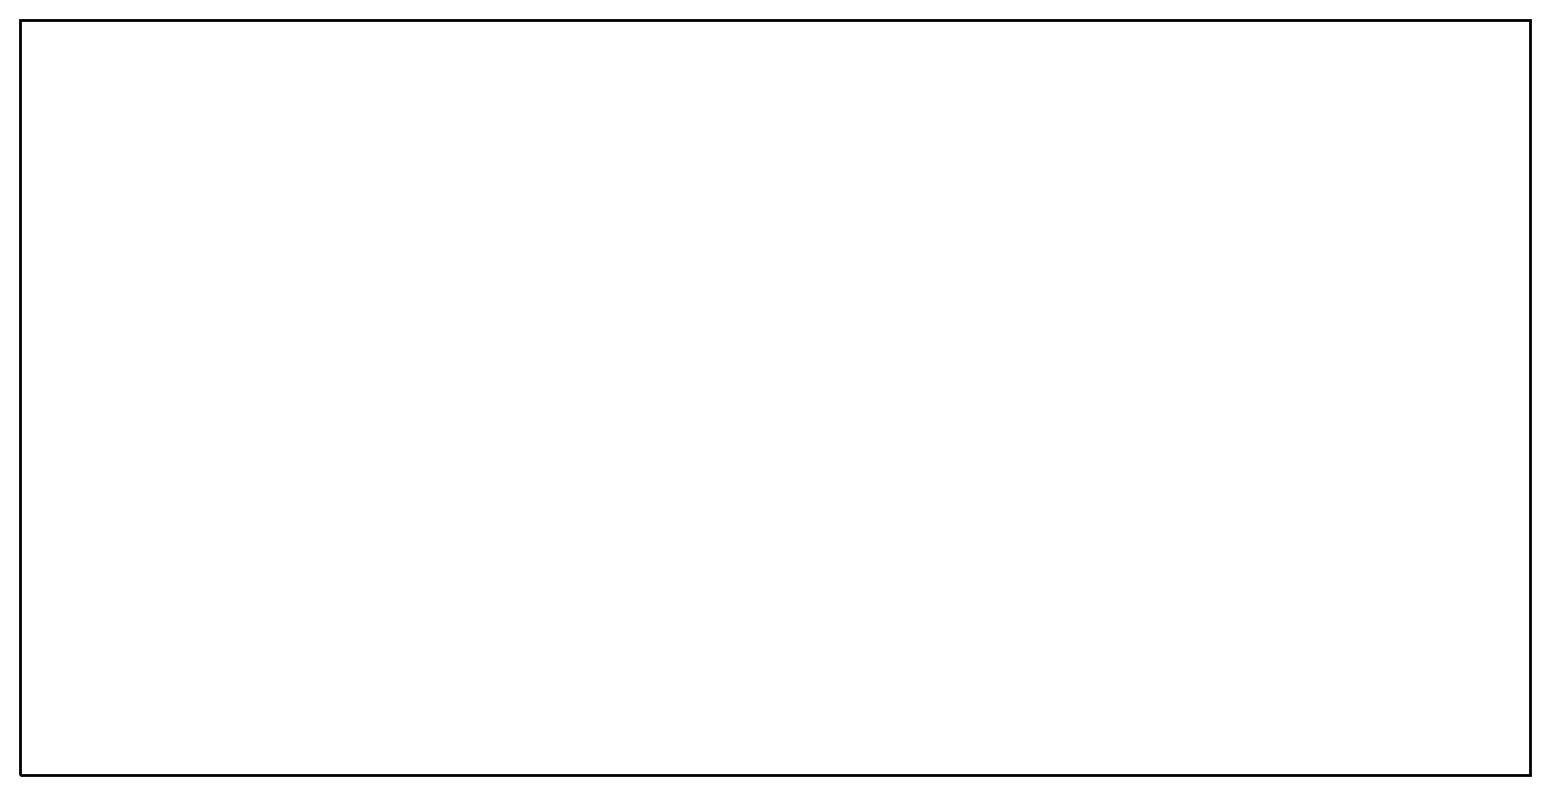

In [40]:
fig = plt.figure(figsize=(10,5), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.imshow(exposure.equalize_hist(nir_reproject.data), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')
ax.text(0.01, 0.02, "Includes material © 2020 Planet Labs Inc. All Rights Reserved.".format("_".join(imagepath.split('_')[:3])), transform=ax.transAxes, fontdict={'color': 'white', 'fontsize' : 7})

ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.7)
plot_mask(nozero_pred, extent, ax, cmap=cmap)
ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)


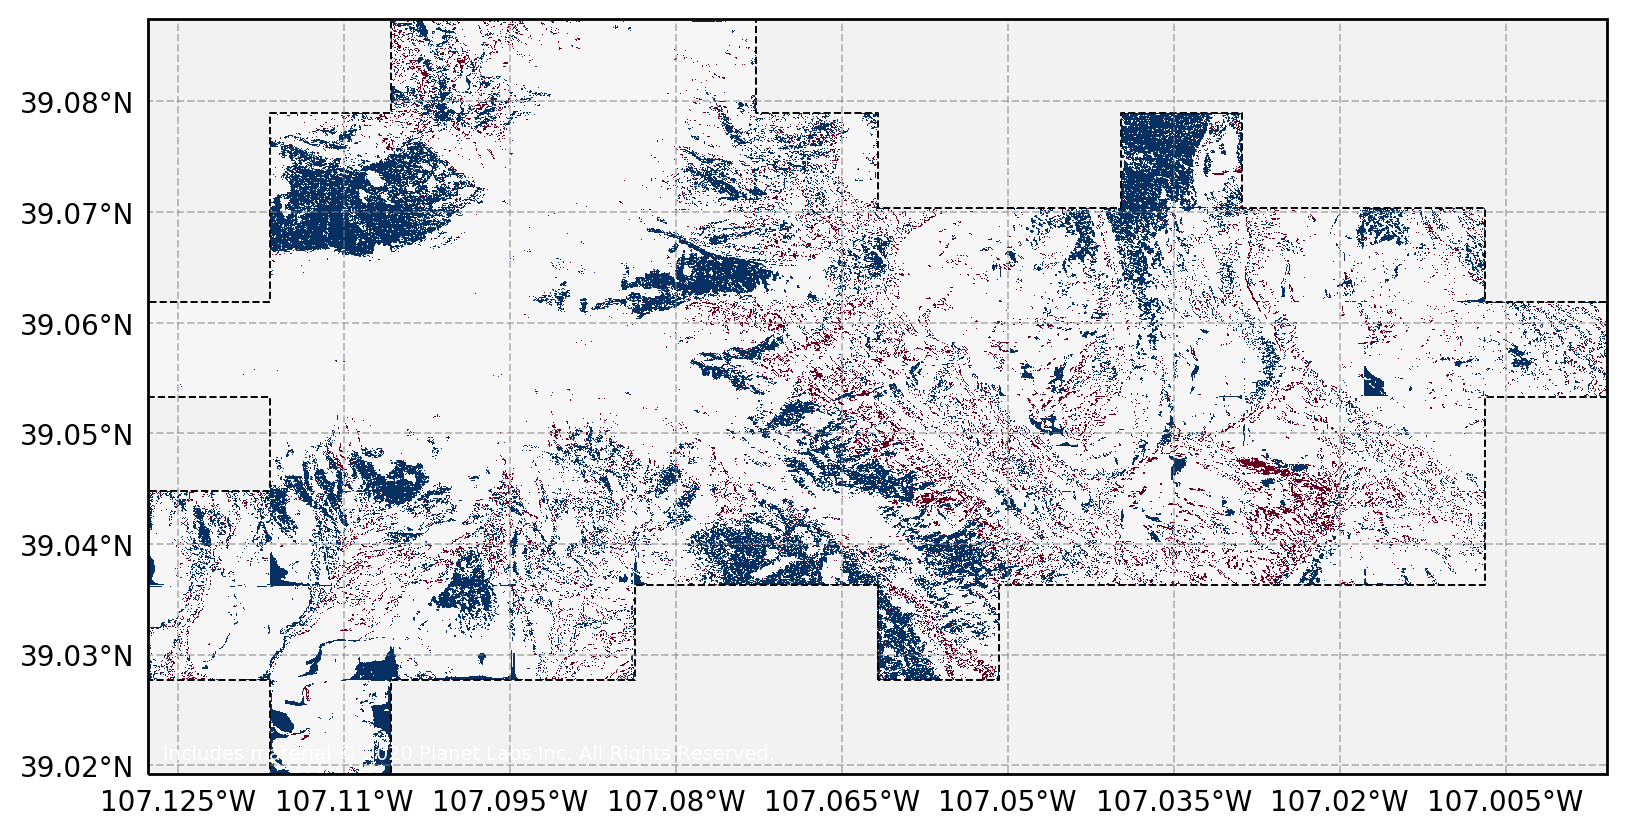

In [147]:
fig = plt.figure(figsize=(10,5), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)
ax.text(0.01, 0.02, "Includes material © 2020 Planet Labs Inc. All Rights Reserved.".format("_".join(imagepath.split('_')[:3])), transform=ax.transAxes, fontdict={'color': 'white', 'fontsize' : 7})
plot_diff(mask_data, pred_data, extent, ax)
ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)


In [152]:
metrics = json.load(open(os.path.join(root, 'aso_metrics.json')))

In [153]:
metrics

{'mask': '/Volumes/wrangell-st-elias/research/planet/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-2020-01-21-21-37-55-126:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/mask/ASO_3M_SD_USCOGE_20180524_binary_merged.tif',
 'preds': '/Volumes/wrangell-st-elias/research/planet/CO/s3:::planet-snowcover-models:ASO-3M-SD-USCASJ-20180601-Step2-2020-01-21-21-37-55-126:planet-snowcover-imagery:20180524_172637_0f2d_3B_AnalyticMS_SR_clip/preds/20180524_172637_0f2d_3B_AnalyticMS_SR_clip_merged.tif',
 'metrics': {'balanced_accuracy': 0.8239252197229334,
  'precision': 0.9069279399092688,
  'recall': 0.7353310838290786,
  'f_score': 0.8121645798484084}}

/Users/tony/miniconda3/envs/process_results/lib/python3.6/site-packages/ipykernel/__main__.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/tony/miniconda3/envs/process_results/lib/python3.6/site-packages/ipykernel/__main__.py:69: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


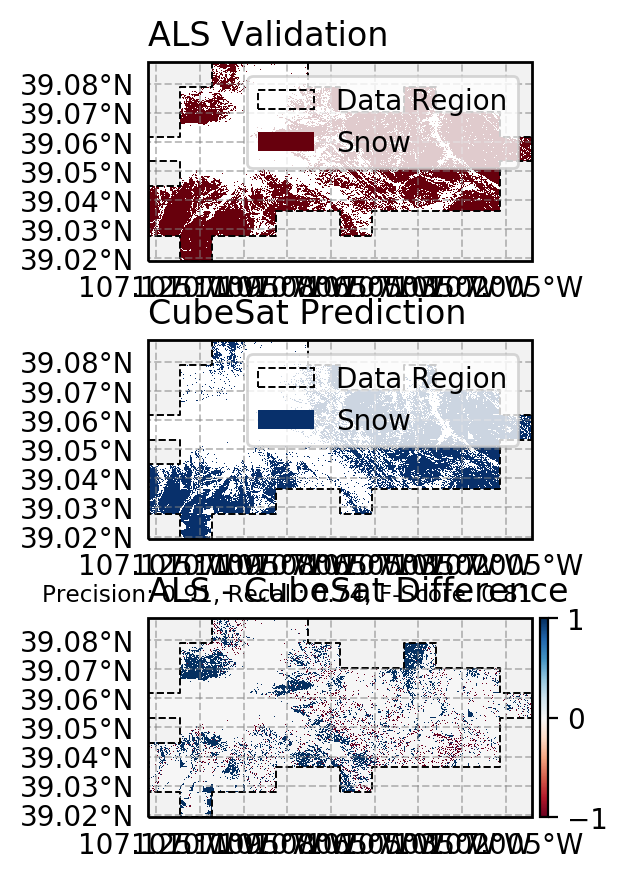

In [175]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



fig = plt.figure(figsize=(10, 5), dpi=200)
gs = fig.add_gridspec(3, 2, hspace=0.4)


mask_ax = fig.add_subplot(gs[0, :-1], projection=ccrs.PlateCarree())
mask_ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)
mask_cmap = plt.cm.get_cmap("Reds", 2)
plot_mask(nozero_mask, extent, mask_ax, mask_cmap)
mask_ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
    (Patch(facecolor=mask_cmap(1), label='Snow'))
]
mask_ax.set_title("ALS Validation", loc='left')
mask_ax.legend(handles=legendParts)

pred_ax = fig.add_subplot(gs[1, :-1], projection=ccrs.PlateCarree())
pred_ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)
pred_cmap = plt.cm.get_cmap("Blues", 2)
plot_mask(nozero_pred, extent, pred_ax, pred_cmap)
pred_ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
    (Patch(facecolor=pred_cmap(1), label='Snow'))
]
pred_ax.set_title("CubeSat Prediction", loc='left')
pred_ax.legend(handles=legendParts)

diff_ax = fig.add_subplot(gs[2, :-1], projection=ccrs.PlateCarree())
diff_ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.1)
colorable = plot_diff(mask_data, pred_data, extent, diff_ax)
diff_ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
diff_ax.set_title("ALS - CubeSat Difference", loc='left')
try: 
    diff_ax.set_title("Precision: {:.2f}, Recall: {:.2f}, F-Score: {:.2f}".format(metrics['metrics']['precision'], metrics['metrics']['recall'], metrics['metrics']['f_score']),
                      loc='right',
                      fontdict={'fontsize':'small', 'fontweight':'light'})
except Exception as e: 
    print("Cannot plot metrics [{}]".format(e))

# cbar_ax = fig.add_subplot(gs[3, :7])
cbar_ax = inset_axes(diff_ax,
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0., 1, 1),
                   bbox_transform=diff_ax.transAxes,
                   borderpad=0,
                   )


# locator_ax = fig.add_subplot(gs[0, 7:-1], projection=ccrs.PlateCarree())
# scaling=0.2
# locator_ax.add_geometries(tuolumne.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1.2)
# locator_ax.add_geometries([geometry.Polygon.from_bounds(*(data_region.bounds.values[0]))], crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none')
# locator_ax.set_extent([tuolumne.bounds.minx-scaling, tuolumne.bounds.maxx+scaling, tuolumne.bounds.miny-scaling, tuolumne.bounds.maxy+scaling])
# locator_ax.outline_patch.set_linewidth(0)
# scalebar.scale_bar(locator_ax, (0.8,0.9), 10, linewidth=8, text_offset=0.04)



cbar = plt.colorbar(colorable, cax=cbar_ax)
# cbar.ax.set_yticklabels(['ALS < ML', '==', 'ALS > ML']) 
gs.tight_layout(fig,)
plt.savefig("test.pdf")

In [185]:
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



fig = plt.figure(figsize=(10, 20), dpi=250)
gs = fig.subplots(4, 1, subplot_kw={"projection" : ccrs.PlateCarree()})


img_ax = gs[0]
img_ax.imshow(exposure.equalize_hist(nir_reproject.data), extent=image_reproject_extent, transform=ccrs.PlateCarree(), origin ='upper', cmap='binary')
img_ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.7)
mask_ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
img_ax.text(0.01, 0.02, "Includes material © 2020 Planet Labs Inc. All Rights Reserved.".format("_".join(imagepath.split('_')[:3])), transform=img_ax.transAxes, fontdict={'color': 'white', 'fontsize' : 7})
img_ax.set_extent(extent, crs=ccrs.PlateCarree())
gl = img_ax.gridlines(crs=ccrs.PlateCarree(),
                      linewidth=0.7, color='gray', alpha=0.5, linestyle='--', draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False
img_ax.set_title("NIR Image", loc='left')
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
]
pred_ax.legend(handles=legendParts)



mask_ax = gs[1]
mask_ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.7)
mask_cmap = plt.cm.get_cmap("Reds", 2)
plot_mask(nozero_mask, extent, mask_ax, mask_cmap)
mask_ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
    (Patch(facecolor=mask_cmap(1), label='Snow'))
]
mask_ax.set_title("ALS Validation", loc='left')
mask_ax.legend(handles=legendParts)

pred_ax = gs[2]
pred_ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.7)
pred_cmap = plt.cm.get_cmap("Blues", 2)
plot_mask(nozero_pred, extent, pred_ax, pred_cmap)
pred_ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
legendParts = [
    (Patch(facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7, label='Data Region')), 
    (Patch(facecolor=pred_cmap(1), label='Snow'))
]
pred_ax.set_title("CubeSat Prediction", loc='left')
pred_ax.legend(handles=legendParts)

diff_ax = gs[3]
diff_ax.add_geometries([nodata_diff], crs=ccrs.PlateCarree(), facecolor='gray', alpha=0.7)
colorable = plot_diff(mask_data, pred_data, extent, diff_ax)
diff_ax.add_geometries(data_region.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='k', linestyle='--', linewidth=0.7)
diff_ax.set_title("ALS - CubeSat Difference", loc='left')
try: 
    diff_ax.set_title("Precision: {:.2f}, Recall: {:.2f}, F-Score: {:.2f}".format(metrics['metrics']['precision'], metrics['metrics']['recall'], metrics['metrics']['f_score']),
                      loc='right',
                      fontdict={'fontsize':'small', 'fontweight':'light'})
except Exception as e: 
    print("Cannot plot metrics [{}]".format(e))

# cbar_ax = fig.add_subplot(gs[3, :7])
cbar_ax = inset_axes(diff_ax,
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0., 1, 1),
                   bbox_transform=diff_ax.transAxes,
                   borderpad=0,
                   )


# locator_ax = fig.add_subplot(gs[0, 7:-1], projection=ccrs.PlateCarree())
# scaling=0.2
# locator_ax.add_geometries(tuolumne.geometry, crs=ccrs.PlateCarree(), facecolor='none', edgecolor='black', linewidth=1.2)
# locator_ax.add_geometries([geometry.Polygon.from_bounds(*(data_region.bounds.values[0]))], crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none')
# locator_ax.set_extent([tuolumne.bounds.minx-scaling, tuolumne.bounds.maxx+scaling, tuolumne.bounds.miny-scaling, tuolumne.bounds.maxy+scaling])
# locator_ax.outline_patch.set_linewidth(0)
# scalebar.scale_bar(locator_ax, (0.8,0.9), 10, linewidth=8, text_offset=0.04)



cbar = plt.colorbar(colorable, cax=cbar_ax)
plt.tight_layout()
# cbar.ax.set_yticklabels(['ALS < ML', '==', 'ALS > ML']) 
plt.savefig("test.pdf")

/Users/tony/miniconda3/envs/process_results/lib/python3.6/site-packages/ipykernel/__main__.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/tony/miniconda3/envs/process_results/lib/python3.6/site-packages/ipykernel/__main__.py:88: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [206]:
import scalebar

In [29]:
from cartopy.io.img_tiles import GoogleTiles

In [32]:
tiles = GoogleTiles(url="https://api.mapbox.com/styles/v1/mapbox/satellite-v9/tiles/256/{z}/{x}/{y}?access_token=pk.eyJ1IjoiYWNhbm5pc3RyYSIsImEiOiJLWVM2RWhJIn0.TputXxRYBUPh-vjDg6_TFA")